In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 2.1 MB 13.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 KB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72858 sha256=cd4271d9b382316ce26e2116eee15b581ee2982d7355b4377ce1862e52a14bdc
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install pydicom
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os

import csv
import random

import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH = '/content'
os.listdir(PATH)

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge
! unzip rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

Loading Datasets

In [ ]:
detailclassinfo_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
trainlabels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
print(f"stage_2_detailed_class_info - rows: {detailclassinfo_df.shape[0]}, columns: {detailclassinfo_df.shape[1]}")
print(f"stage_2_train_labels - rows: {trainlabels_df.shape[0]}, columns: {trainlabels_df.shape[1]}")

stage_2_detailed_class_info - rows: 30227, columns: 2
stage_2_train_labels - rows: 30227, columns: 6


In [ ]:
os.listdir(PATH)

['.config',
 'stage_2_train_labels.csv',
 'stage_2_test_images',
 'stage_2_detailed_class_info.csv',
 'stage_2_sample_submission.csv',
 'GCP Credits Request Link - RSNA.txt',
 'rsna-pneumonia-detection-challenge.zip',
 'stage_2_train_images',
 'drive',
 'sample_data']

In [ ]:
detailclassinfo_df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [ ]:
trainlabels_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [ ]:
print('Shape of Detailed Class Information: {}'.format(detailclassinfo_df.shape))
print('Shape of Train Labels: {}'.format(trainlabels_df.shape))

Shape of Detailed Class Information: (30227, 2)
Shape of Train Labels: (30227, 6)


Basic EDA

In [ ]:
# Merging Datasets

merge_train_df = trainlabels_df.merge(detailclassinfo_df, left_on='patientId', right_on='patientId', how='inner')
merge_train_df.sample(5)



patientId      x  ...  Target         class
8327   4c7fc3dd-9dda-4ee5-85e5-9b6136e1ce64   60.0  ...       1  Lung Opacity
20982  a332b7c6-2db8-4158-a01b-ab2baff58cdc  533.0  ...       1  Lung Opacity
22913  ae0cf0fc-7856-4d95-99b6-f2fd77c753f3    NaN  ...       0        Normal
5871   3d04aef0-2bb8-4de2-a871-4c814bca5d9b  505.0  ...       1  Lung Opacity
18800  93a95c68-c487-4e09-89e2-6e3849e44886  535.0  ...       1  Lung Opacity

[5 rows x 7 columns]

In [ ]:
print('Shape of merged dataset: {}'.format(merge_train_df.shape))

Shape of merged dataset: (37629, 7)


merging has increased the number of records, indicating there are some duplicate recrods which need to be deleted

In [ ]:
merge_train_df = merge_train_df. drop_duplicates()
merge_train_df.shape

(30227, 7)

In [ ]:
merge_train_df.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

Bounding box params are having NULL values for records where pneumonia is not detected

Distribution of classes

In [ ]:
detailclassinfo_df.groupby(["class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

In [ ]:
merge_train_df.groupby(["class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

9555 patients are in class of 'Lung Opacity', 11821 are in 'No Lung Opacity / Not Normal' and 8851 are in Normal category.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


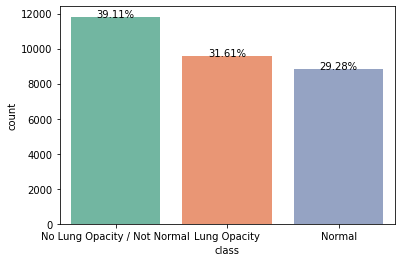

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(merge_train_df))
sns.countplot(merge_train_df['class'],order = merge_train_df['class'].value_counts().index, palette='Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

The classes "No Lung Opacity / Not Normal", "Lung Opacity" and "Normal" are in the proportions of 39%, 32% and 29% respectively

Distribution of Labels (Positive and Negative)

In [ ]:
import plotly.express as px

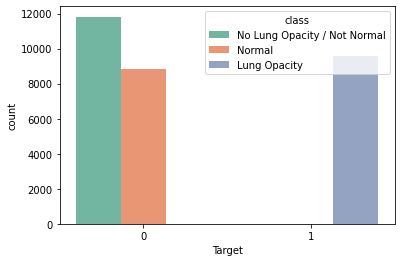

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(x = "Target", data= merge_train_df, hue="class", palette='Set2')

In [ ]:
px.histogram(merge_train_df, x="class", color = "Target", marginal="box", hover_data=merge_train_df.columns, text_auto=True, nbins = 5)

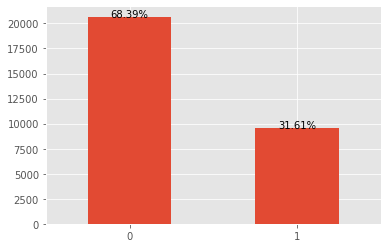

In [ ]:
plt.style.use('ggplot')
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(merge_train_df))
pd.value_counts(merge_train_df["Target"]).plot(kind='bar', position=0.5, rot=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [ ]:
px.histogram(merge_train_df, x="Target", marginal="violin", hover_data=merge_train_df.columns, text_auto=True)

In [ ]:
# Number of positive targets
print(round((9555 / (9555 + 20672)) * 100, 2), '% of the patients are positive')

31.61 % of the patients are positive


In [ ]:
merge_train_df.groupby(["Target"]).count()

patientId     x     y  width  height  class
Target                                             
0           20672     0     0      0       0  20672
1            9555  9555  9555   9555    9555   9555

Patients with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal don't have bounding box coordinates (x, y, w, h) parameters.
31.61% of the patients belongs to Lung Opacity class.

Creating a Bounding box DF

In [ ]:
merge_bb_df = merge_train_df.drop(columns = ["patientId", "class"])
merge_bb_df.head()

x      y  width  height  Target
0    NaN    NaN    NaN     NaN       0
1    NaN    NaN    NaN     NaN       0
2    NaN    NaN    NaN     NaN       0
3    NaN    NaN    NaN     NaN       0
4  264.0  152.0  213.0   379.0       1

In [ ]:
# Impute NaN with KNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
merge_bb_imputed_df = imputer.fit_transform(merge_bb_df) # this creates an array

# Converted array to dataframe
merge_bb_final = pd.DataFrame(data=merge_bb_imputed_df, columns=["x", "y", "width", "height", "Target"])
merge_bb_final["Target"] = merge_bb_final["Target"].astype('int64')
merge_bb_final.head(5)



x      y  width  height  Target
0  413.0  152.0  234.5   416.0       0
1  413.0  152.0  234.5   416.0       0
2  413.0  152.0  234.5   416.0       0
3  413.0  152.0  234.5   416.0       0
4  264.0  152.0  213.0   379.0       1

In [ ]:
# Seggregating Opacity data from imputed data (Target =1 )
opacity_bb_final = merge_bb_final[(merge_bb_final['Target']== 1)]
opacity_bb_final.head()

x      y  width  height  Target
4   264.0  152.0  213.0   379.0       1
5   562.0  152.0  256.0   453.0       1
8   323.0  577.0  160.0   104.0       1
9   695.0  575.0  162.0   137.0       1
14  288.0  322.0   94.0   135.0       1

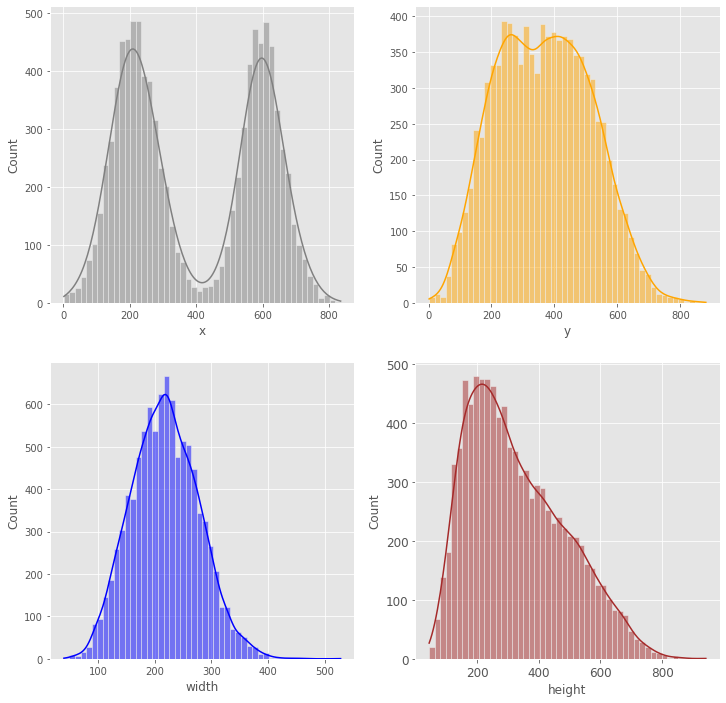

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.histplot(opacity_bb_final['x'],kde=True,bins=50, color="grey", ax=ax[0,0])
sns.histplot(opacity_bb_final['y'],kde=True,bins=50, color="orange", ax=ax[0,1])
sns.histplot(opacity_bb_final['width'],kde=True,bins=50, color="blue", ax=ax[1,0])
sns.histplot(opacity_bb_final['height'],kde=True,bins=50, color="brown", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

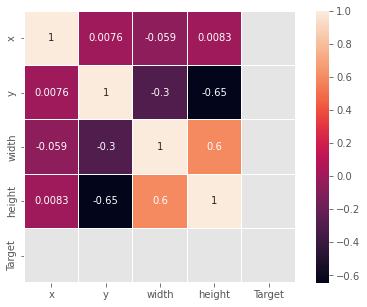

In [ ]:
# Correlation
plt.figure(figsize=(7,5))
sns.heatmap(opacity_bb_final.corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

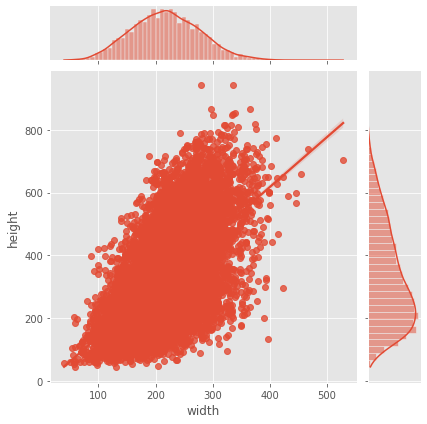

In [ ]:
sns.jointplot(x = 'width', y = 'height', data = opacity_bb_final, kind= 'reg')

There is a fine correlation between width and height variables, which is obvious.

Lung Opacity for 2000 samples

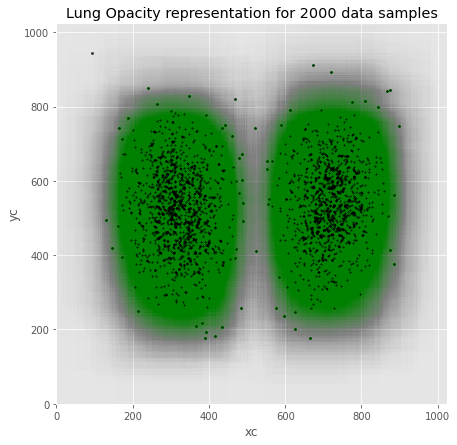

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = opacity_bb_final.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Lung Opacity representation for 2000 data samples")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="black")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="green"))
plt.show()

Split Data sets (Train= 80%, Test= 20%)

In [ ]:
tmp = merge_train_df[["patientId", "class"]]
train_labels_data = pd.merge(tmp, merge_bb_final, how= 'inner', left_index=True, right_index=True)
train_labels_data.head()

patientId  ... Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...      0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...      0
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...      0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...      0
4  00436515-870c-4b36-a041-de91049b9ab4  ...      1

[5 rows x 7 columns]

In [ ]:
X = train_labels_data.drop(columns= ["patientId", "Target", "class"])
y = train_labels_data[["Target"]]
X.shape, y.shape

((23975, 4), (23975, 1))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score, auc, plot_confusion_matrix, plot_roc_curve, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =7)
print('Training data shape:', (X_train.shape, y_train.shape))
print('Test data shape:', (X_test.shape, y_test.shape))


Training data shape: ((19180, 4), (19180, 1))
Test data shape: ((4795, 4), (4795, 1))


Classification using SVC

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'rbf', C = 1.0).fit(X_train, y_train.values.ravel())
y_preds = svm_model.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_preds))
print('Average Precision Score:', average_precision_score(y_test, y_preds))

Accuracy score: 1.0
Average Precision Score: 1.0


In [ ]:
print('Score: "{:.2%}"'.format(svm_model.score(X, y)))

Score: "99.99%"


In [ ]:
print('Classification report: \n')
print(classification_report(y_test, y_preds))

Classification report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3277
           1       1.00      1.00      1.00      1518

    accuracy                           1.00      4795
   macro avg       1.00      1.00      1.00      4795
weighted avg       1.00      1.00      1.00      4795



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



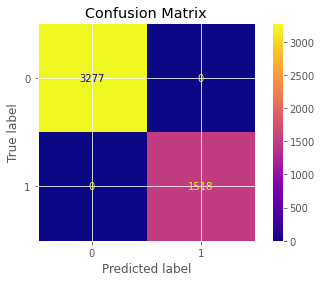

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test, values_format='d', cmap ='plasma')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



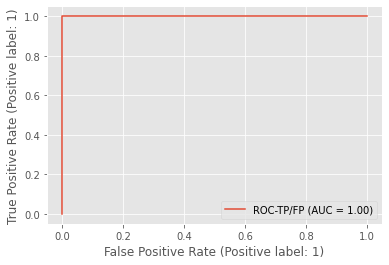

In [ ]:
plot_roc_curve(svm_model, X_test, y_test, name= 'ROC-TP/FP')

In [ ]:
pr, tpr, thresholds = roc_curve(y_test, y_preds)

# calculate AUC
auc = roc_auc_score(y_test, y_preds)
print('AUC: %.3f' % auc)

AUC: 1.000


Using Pydicom to analyze .dcm images

In [ ]:
# Load data

patientId = trainlabels_df['patientId'][0]
dcm_file = PATH+'/stage_2_train_images/%s.dcm' % patientId
dcm_data = dcm.read_file(dcm_file)
print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

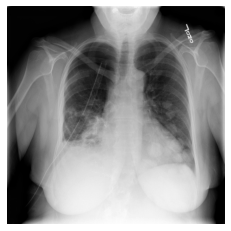

In [ ]:
import pylab
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

Plot bounding boxes over Images

In [ ]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': PATH+'/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(trainlabels_df)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = dcm.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [0, 0, 255] # Just use blue
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

Train Labels dataset images

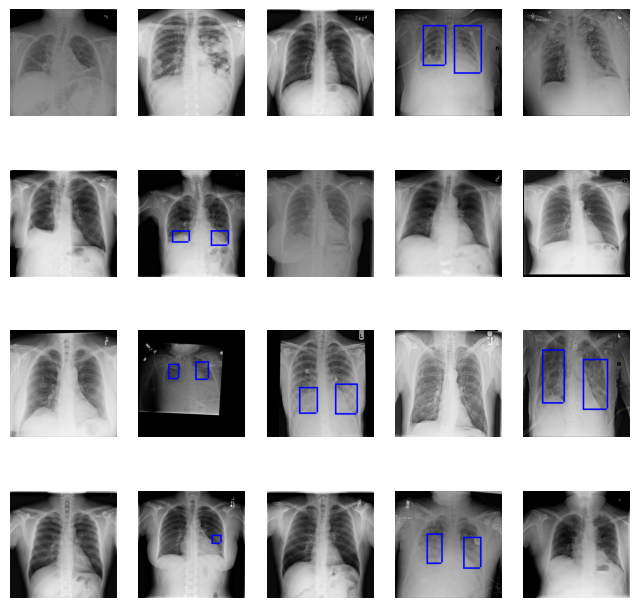

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(8, 8))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[trainlabels_df['patientId'].unique()[i]])
    fig.add_subplot

Detail Class dataset images

In [ ]:
opacity = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'Lung Opacity'] \
    .reset_index()

not_normal = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()

normal = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'Normal'] \
    .reset_index()

1. Lung Opacity Samples

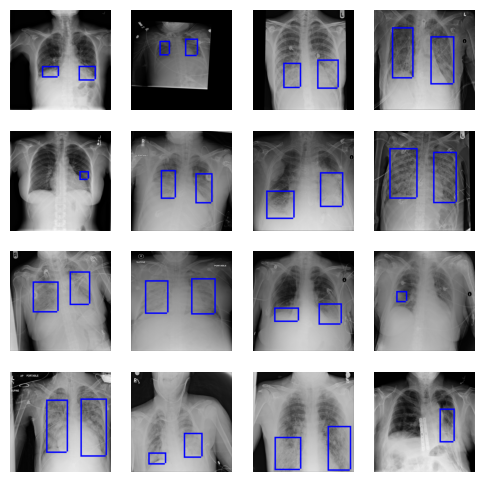

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[opacity['patientId'].unique()[i]])

2. Normal Samples

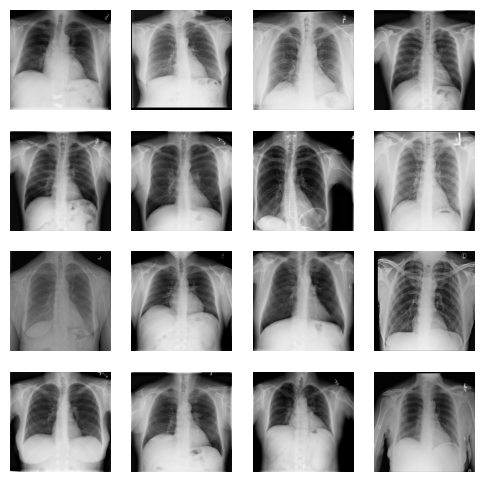

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[normal['patientId'].unique()[i]])

3. No Lung Opacity/Not Normal Samples

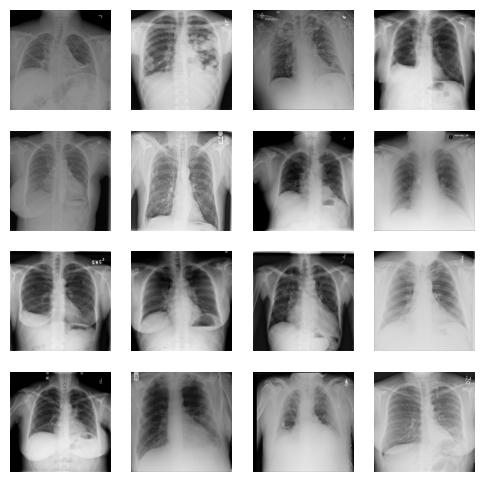

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[not_normal['patientId'].unique()[i]])

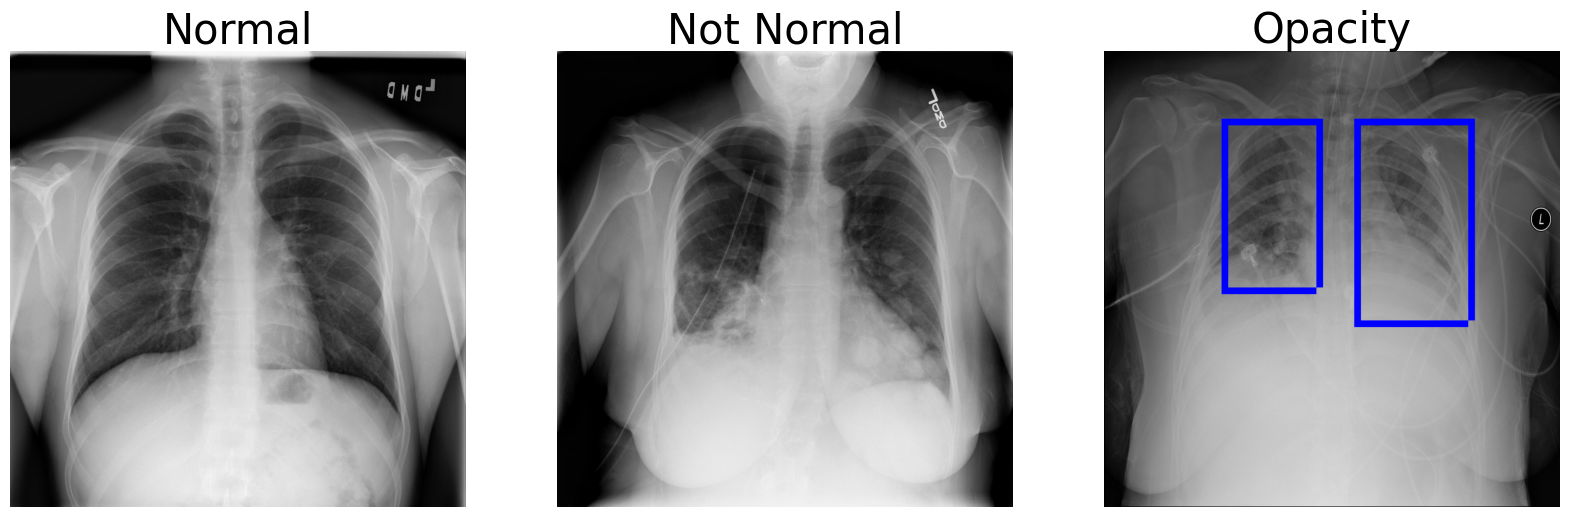

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[0]])

Image Segmentation using class generatortransfer

Model Selection

In [ ]:
#Load opacity locations

opacity_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        lungopacity = rows[5]
        # if row contains lungopacity add label to dictionary
        # which contains a list of lungopacity locations per filename
        if lungopacity == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save lungopacity location in dictionary
            if filename in opacity_locations:
                opacity_locations[filename].append(location)
            else:
                opacity_locations[filename] = [location]

In [ ]:
# Load file names

folder = PATH+'/stage_2_train_images'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))
print('First 5 samples: \n')
filenames[0:5]

Number of Train images: 26684
First 5 samples: 



['6cceaf55-c53d-4732-9436-85db3e219a62.dcm',
 '986237d6-e05f-4ce0-82e9-b81feb7fc399.dcm',
 '53944b3e-99f2-4a21-816e-a85673595b26.dcm',
 'e80c61ff-3f37-4838-8969-6e850a7f8cfb.dcm',
 'b858e525-59a0-4e31-a893-6698f934c5cd.dcm']

In [ ]:
# Splitting file names in Train and Test

random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 5336
n_train_samples = len(filenames) - n_valid_samples
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('Total file samples:', len(filenames))
print('Train samples (80%):', len(train_filenames))
print('Valid samples (20%):', len(valid_filenames))

Total file samples: 26684
Train samples (80%): 21348
Valid samples (20%): 5336


In [ ]:
# Downsampling Train samples

n_downsamples = 5336
train_dsamps = train_filenames[:n_downsamples]
print('Training Downsamples:', len(train_dsamps))

Training Downsamples: 5336


Transfer Learning

In [ ]:
!pip install opencv-python
import cv2
keras = tf.compat.v1.keras
#Sequence = keras.utils.Sequence

Define class generatortransfer

In [ ]:
class generatortransfer(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, opacity_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.opacity_locations = opacity_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains lung opacity
        if filename in opacity_locations:
            # loop through opacity
            for location in opacity_locations[filename]:
                # add 1's at the location of the lung opacity
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        msk = np.expand_dims(msk, -1)
         #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
            img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
          img = np.stack((img,) * 3, -1)
          img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
img_width = 128
img_height = 128
IMAGE_SIZE=128
kernel =3
num_of_classes =2
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE=1000


In [ ]:
# create training and validation data
folder = PATH+'/stage_2_train_images'
train_trans = generatortransfer(folder, train_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_trans = generatortransfer(folder, valid_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)
#train_downsamples = generatortransfer(folder, tune_train_samples, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

In [ ]:
import keras
from tensorflow.keras import Sequential, backend as K
#from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(ResNet50(input_shape= (img_width, img_height, 3), include_top=False, weights='imagenet'))
model.add(Dense(1024, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(512, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(256, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(64, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(8, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(1, activation='sigmoid'))
# Don't train first layer (ResNet) model
model.layers[0].trainable = False
print(model.summary())

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 4, 4, 1024)        2098176   
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 1024)       0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 8, 8, 512)         524800    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 512)      0         
 2D)                                                             
                                                         

In [ ]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_trans, epochs=5, steps_per_epoch =10, shuffle=True)

Epoch 1/5
10/10 [==============================] - 26s 2s/step - loss: 0.3744 - accuracy: 0.8762
Epoch 2/5
10/10 [==============================] - 20s 2s/step - loss: 0.1680 - accuracy: 0.9744
Epoch 3/5
10/10 [==============================] - 20s 2s/step - loss: 0.1467 - accuracy: 0.9710
Epoch 4/5
10/10 [==============================] - 20s 2s/step - loss: 0.1349 - accuracy: 0.9701
Epoch 5/5
10/10 [==============================] - 21s 2s/step - loss: 0.1125 - accuracy: 0.9715


In [ ]:
model.evaluate(valid_trans)

333/333 [==============================] - 629s 2s/step - loss: 0.1004 - accuracy: 0.9750


[0.10044334083795547, 0.9749834537506104]